# Multi-Class Classification Model for Diabetes Readmission Prediction Using Python Take 1
### David Lowe
### May 6, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Diabetes Readmission Prediction is a multi-class classification situation where we are trying to predict one of the several possible outcomes.

INTRODUCTION: Management of hyperglycemia in hospitalized patients has a significant bearing on the outcome, in terms of both morbidity and mortality. However, there are few national assessments of diabetes care during hospitalization which could serve as a baseline for change. This analysis of a large clinical database was undertaken to provide such an assessment and to find future directions which might lead to improvements in patient safety. The statistical model suggests that the relationship between the probability of readmission and the HbA1c measurement depends on the primary diagnosis. The data suggest further that the greater attention to diabetes reflected in HbA1c determination may improve patient outcomes and lower cost of inpatient care.

In this iteration, we plan to establish the baseline prediction accuracy for further takes of modeling. To limit the processing time and memory requirements, we also will limit the attributes used for this project by not including those attributes that do not appear on the final model of the research paper.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 53.71%. Two algorithms (Linear Discriminant Analysis and Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Gradient Boosting turned in the top overall result and achieved an accuracy metric of 58.78%. By using the optimized parameters, the Bagged Decision Trees algorithm processed the testing dataset with an accuracy of 58.41%, which was just slightly below the prediction accuracy from the training data.

CONCLUSION: For this iteration, the Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, Gradient Boosting should be considered for further modeling or production use.

Dataset Used: Diabetes 130-US hospitals for years 1999-2008 Data Set

Dataset ML Model: Multi-Class classification with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

One source of potential performance benchmarks: http://www.hindawi.com/journals/bmri/2014/781670/

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + ' downloaded!')
    print('Unpacking ' + dest_file)
    with zipfile.ZipFile(dest_file, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(dest_file + ' unpacked!')

inputFile = 'dataset_diabetes/diabetic_data.csv'
xy_original_df = read_csv(inputFile, sep=',', index_col=False, na_values="?")

/home/dlowe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Show the initial state of the dataframe columns before clean-up
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non

In [6]:
print(xy_original_df.isnull().sum())

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [7]:
# Perform the initial clean-up of the dataframe
# Remove the following attributes that are unique IDs, with many missing values, or not used by the research paper
xy_original_df.drop(columns=['encounter_id','patient_nbr','gender','weight','admission_type_id',
                             'payer_code','medical_specialty','diag_2','diag_3'], inplace=True)

# Remove the 23 attributes for medications that have only one value in the column or with very little variation
xy_original_df.drop(columns=['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
                             'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
                             'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
                             'examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',
                             'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], inplace=True)

# impute the missing values into the primary diagnostic fields
xy_original_df['diag_1'].fillna('000', inplace=True)

In [8]:
# Construct the code table to translate the diagnose code to its corresponding category
def reClassDiagnose(diag_code):
    code_table  = [
        ('000', 'NotApplicable'),
        ('^(1[4-9][0-9]|2[0-3][0-9])', 'Neoplasms'),
        ('^250', 'Diabetes'),
        ('^(39[0-9]|4[0-5][0-9]|785)','Circulatory'),
        ('^(4[6-9][0-9]|5[0-1][0-9]|786)','Respiratory'),
        ('^(5[2-7][0-9]|787)','Digestive'),
        ('^(5[8-9][0-9]|6[0-2][0-9]|788)', 'Genitourinary'),
        ('^(7[1-3][0-9])','Musculoskeletal'),
        ('^([8-9][0-9][0-9])','Injury'),
    ]
    for pattern, value in code_table:
        if re.search(pattern, diag_code):
            return value
    return 'Other'

In [9]:
xy_original_df['diag_1'] = xy_original_df['diag_1'].apply(reClassDiagnose)

In [10]:
xy_original_df['discharge_disposition_id'] = xy_original_df.discharge_disposition_id.astype('category')
xy_original_df['admission_source_id'] = xy_original_df.admission_source_id.astype('category')
xy_original_df['targetVar'] = 0
xy_original_df.loc[xy_original_df['readmitted']=='<30', 'targetVar'] = 1
xy_original_df.loc[xy_original_df['readmitted']=='>30', 'targetVar'] = 2
xy_original_df.drop(columns=['readmitted'], inplace=True)
xy_original_df = pd.concat([
    xy_original_df.select_dtypes([], ['object']),
    xy_original_df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1).reindex(xy_original_df.columns, axis=1)

In [11]:
# Show the final state of the dataframe columns after clean-up
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 18 columns):
race                        99493 non-null category
age                         101766 non-null category
discharge_disposition_id    101766 non-null category
admission_source_id         101766 non-null category
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null category
number_diagnoses            101766 non-null int64
max_glu_serum               101766 non-null category
A1Cresult                   101766 non-null category
change                      101766 non-null category
diabetesMed                 101766 non-null category
targetVar    

In [12]:
print(xy_original_df.isnull().sum())

race                        2273
age                            0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
change                         0
diabetesMed                    0
targetVar                      0
dtype: int64


In [13]:
xy_original_df.groupby('targetVar').size()

targetVar
0    54864
1    11357
2    35545
dtype: int64

In [14]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [15]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
# xy_original_df = xy_original_df.rename(columns={'Type': 'targetVar'})

In [16]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (101766, 18) xy_train_df.shape: (71236, 18)
x_train_df.shape: (71236, 17) y_train_df.shape: (71236,)
x_test_df.shape: (30530, 17) y_test_df.shape: (30530,)


### 1.d) Set up the key parameters to be used in the script

In [17]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = 6

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [20]:
xy_train_df.head()

,race,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,targetVar
70310,Caucasian,[70-80),1,7,12,64,4,19,0,0,0,Other,9,None,>7,Ch,Yes,2
33887,Caucasian,[80-90),6,17,5,11,0,21,4,1,0,Respiratory,9,>200,None,Ch,Yes,0
91965,Caucasian,[50-60),1,1,2,25,3,27,0,0,0,Injury,6,None,None,Ch,Yes,0
28063,AfricanAmerican,[60-70),1,6,7,66,4,20,0,0,2,Circulatory,5,None,None,No,No,0
62416,Caucasian,[70-80),6,7,8,68,0,20,1,0,1,Circulatory,9,None,None,No,Yes,2


#### 2.a.ii) Dimensions of the dataset.

In [21]:
xy_train_df.shape

(71236, 18)

#### 2.a.iii) Types of the attributes.

In [22]:
xy_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 70310 to 10750
Data columns (total 18 columns):
race                        69613 non-null category
age                         71236 non-null category
discharge_disposition_id    71236 non-null category
admission_source_id         71236 non-null category
time_in_hospital            71236 non-null int64
num_lab_procedures          71236 non-null int64
num_procedures              71236 non-null int64
num_medications             71236 non-null int64
number_outpatient           71236 non-null int64
number_emergency            71236 non-null int64
number_inpatient            71236 non-null int64
diag_1                      71236 non-null category
number_diagnoses            71236 non-null int64
max_glu_serum               71236 non-null category
A1Cresult                   71236 non-null category
change                      71236 non-null category
diabetesMed                 71236 non-null category
targetVar                  

#### 2.a.iv) Statistical summary of all attributes.

In [23]:
xy_train_df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,targetVar
count,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000
mean,4.391993,43.069150,1.342355,16.000533,0.364465,0.200432,0.634890,7.417387,0.806376
std,2.981419,19.676882,1.704674,8.122761,1.250032,0.966544,1.262483,1.935990,0.922294
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,2.000000
max,14.000000,126.000000,6.000000,81.000000,40.000000,76.000000,21.000000,16.000000,2.000000


#### 2.a.v) Count missing values.

In [24]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 race                        1623
age                            0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
change                         0
diabetesMed                    0
targetVar                      0
dtype: int64
Total number of NaN in the dataframe:  1623


#### 2.a.vi) Summarize the levels of the class attribute.

In [25]:
xy_train_df.groupby('targetVar').size()

targetVar
0    38529
1     7971
2    24736
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

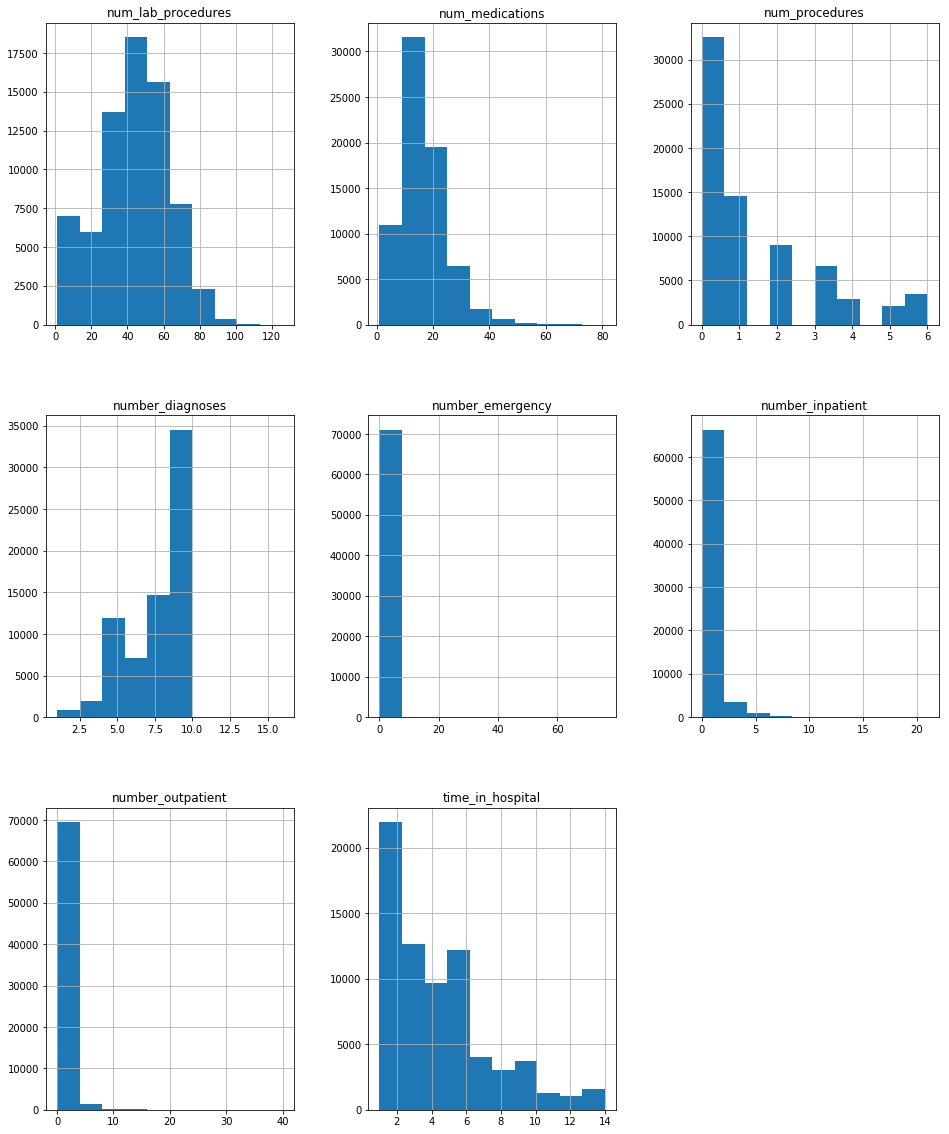

In [26]:
# Histograms for each attribute
x_train_df.hist()
pyplot.show()

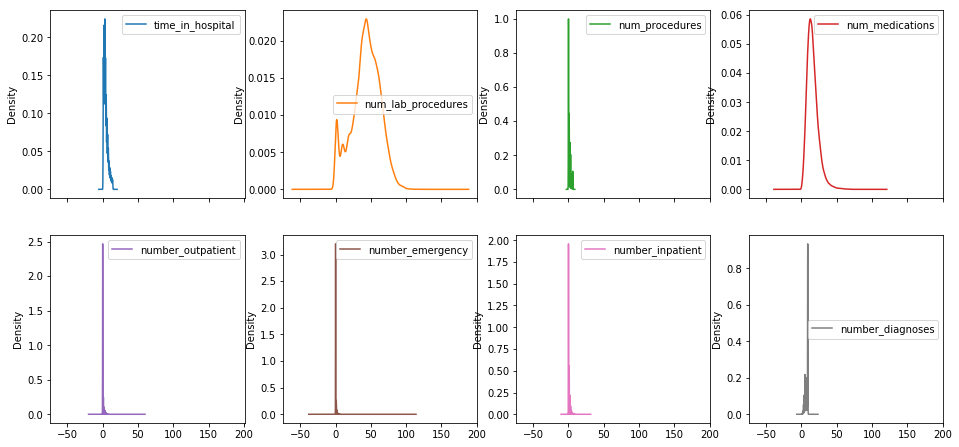

In [27]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

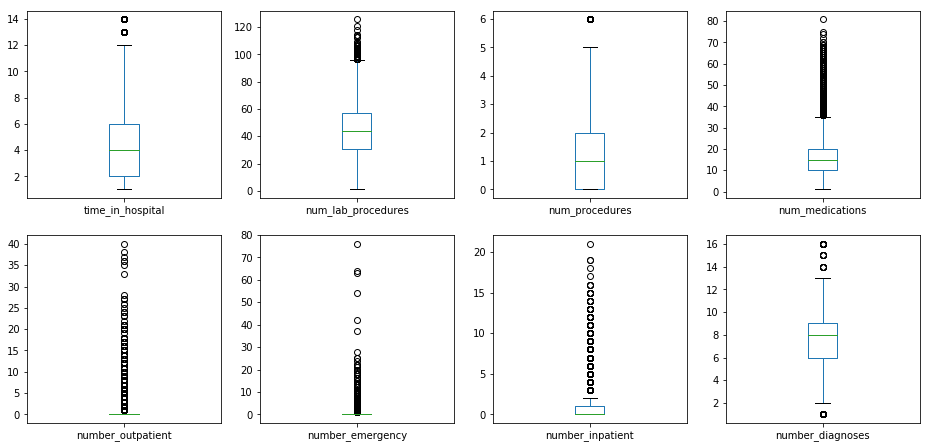

In [28]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [29]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

In [30]:
# Correlation matrix
# fig = pyplot.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = x_train_df.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# pyplot.show()

In [31]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [32]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [33]:
# Not applicable for this iteration of the project
# Sample code for performing one-hot-encoding (Block #1 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
x_train_df = get_dummies(x_train_df)
print(x_train_df.dtypes)

time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
number_diagnoses              int64
race_AfricanAmerican          uint8
race_Asian                    uint8
race_Caucasian                uint8
race_Hispanic                 uint8
race_Other                    uint8
age_[0-10)                    uint8
age_[10-20)                   uint8
age_[20-30)                   uint8
age_[30-40)                   uint8
age_[40-50)                   uint8
age_[50-60)                   uint8
age_[60-70)                   uint8
age_[70-80)                   uint8
age_[80-90)                   uint8
age_[90-100)                  uint8
discharge_disposition_id_1    uint8
discharge_disposition_id_2    uint8
discharge_disposition_id_3    uint8
discharge_disposition_id_4    uint8
discharge_disposition_id_5  

In [34]:
# Sample code for performing one-hot-encoding (Block #2 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
x_test_df = get_dummies(x_test_df)
print(x_test_df.dtypes)

time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
number_diagnoses              int64
race_AfricanAmerican          uint8
race_Asian                    uint8
race_Caucasian                uint8
race_Hispanic                 uint8
race_Other                    uint8
age_[0-10)                    uint8
age_[10-20)                   uint8
age_[20-30)                   uint8
age_[30-40)                   uint8
age_[40-50)                   uint8
age_[50-60)                   uint8
age_[60-70)                   uint8
age_[70-80)                   uint8
age_[80-90)                   uint8
age_[90-100)                  uint8
discharge_disposition_id_1    uint8
discharge_disposition_id_2    uint8
discharge_disposition_id_3    uint8
discharge_disposition_id_4    uint8
discharge_disposition_id_5  

### 3.b) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.c) Data Transforms

In [36]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [37]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (71236, 88) y_train.shape: (71236,)
x_test.shape: (30530, 88) y_test.shape: (30530,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, and eXtreme Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [38]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [39]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier(n_jobs=cpu_num)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
# models.append(('GBM', GradiengBoostingClassifier(random_state=seedNum)))
models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [40]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/dlowe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

LDA: 0.575327 (0.005301)
Model training time: 0:00:09.649984
CART: 0.470520 (0.003097)
Model training time: 0:00:27.538224
KNN: 0.516888 (0.004247)
Model training time: 0:01:35.286598
BT: 0.539053 (0.003994)
Model training time: 0:00:22.015583
RF: 0.543321 (0.004925)
Model training time: 0:00:08.317221
ET: 0.530462 (0.005712)
Model training time: 0:00:10.896324
XGB: 0.584283 (0.005815)
Model training time: 0:01:14.665009
Average metrics (accuracy) from all models: 0.5371221876096852


### 4.b) Spot-checking baseline algorithms

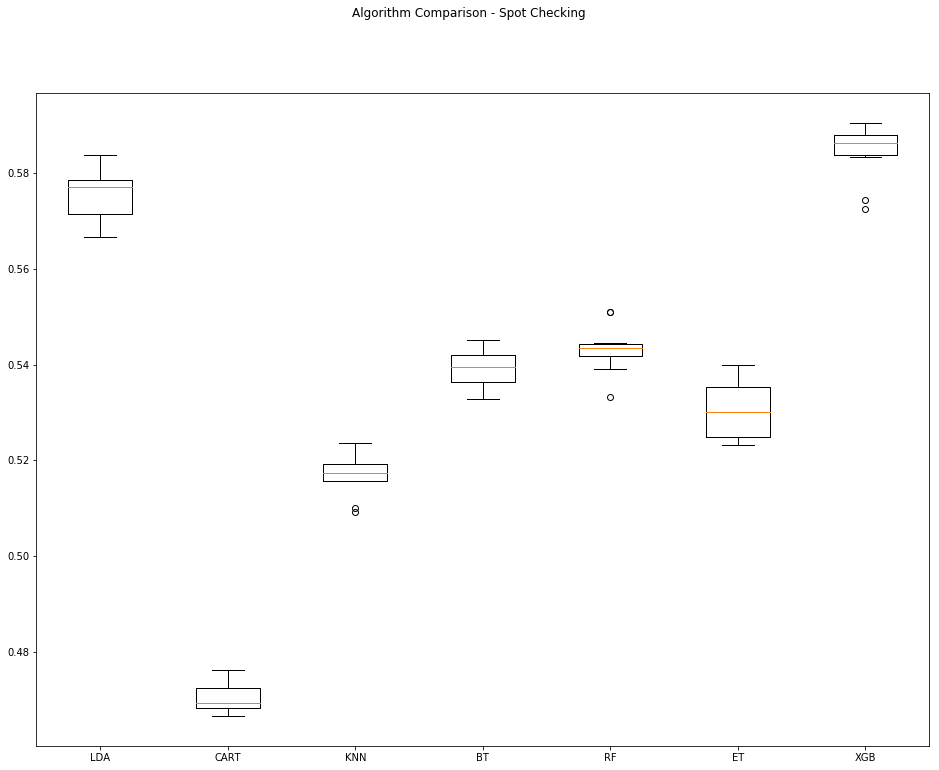

In [41]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [42]:
# Set up the comparison array
results = []
names = []

In [43]:
# Tuning algorithm #1 - Linear Discriminant Analysis
# LDA has no special tuning requirements, so we are skipping this section.
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
# paramGrid1 = dict(n_estimators=np.array([100,250,400,500]))
# model1 = LinearDiscriminantAnalysis()
# kfold = KFold(n_splits=num_folds, random_state=seedNum)
# grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
# grid_result1 = grid1.fit(x_train, y_train)

# print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
# results.append(grid_result1.cv_results_['mean_test_score'])
# names.append('XGB')
# means = grid_result1.cv_results_['mean_test_score']
# stds = grid_result1.cv_results_['std_test_score']
# params = grid_result1.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
# print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [44]:
# Tuning algorithm #2 - Gradient Boosting
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([100,250,350,500]))
model2 = XGBClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('XGB')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.587891 using {'n_estimators': 350}
0.584283 (0.005815) with: {'n_estimators': 100}
0.586571 (0.006073) with: {'n_estimators': 250}
0.587891 (0.006325) with: {'n_estimators': 350}
0.587877 (0.006506) with: {'n_estimators': 500}
Model training time: 0:15:15.056819


### 5.b) Compare Algorithms After Tuning

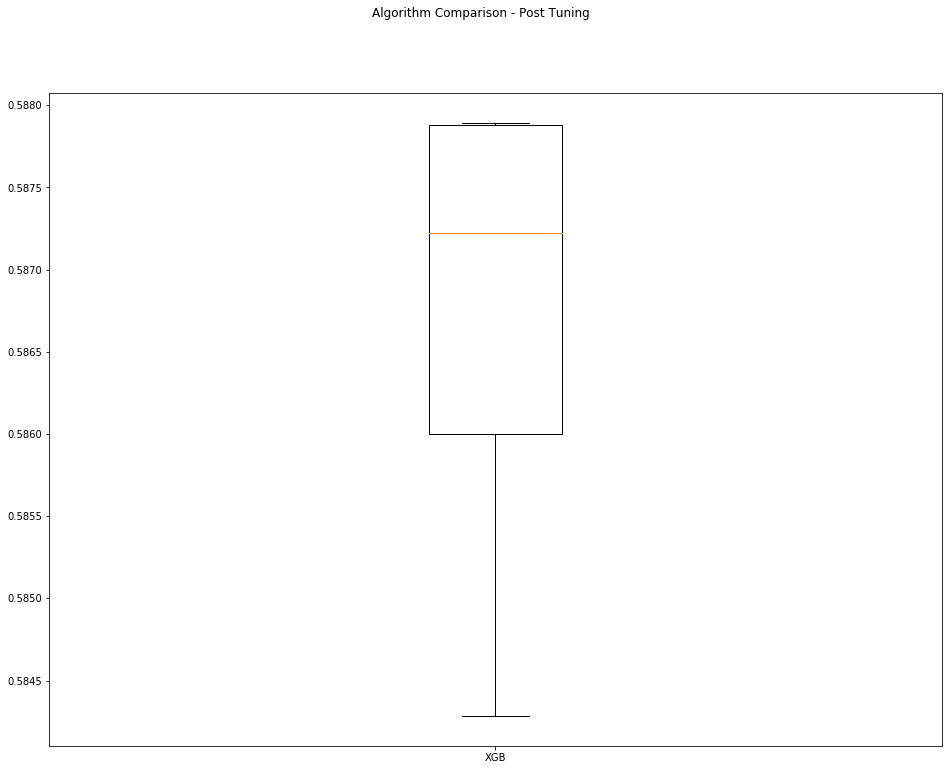

In [45]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [46]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [47]:
model = XGBClassifier(n_estimators=350, random_state=seedNum, n_jobs=cpu_num)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.5841794955781199
[[13884    31  2420]
 [ 2094    92  1200]
 [ 6862    88  3859]]
              precision    recall  f1-score   support

           0       0.61      0.85      0.71     16335
           1       0.44      0.03      0.05      3386
           2       0.52      0.36      0.42     10809

   micro avg       0.58      0.58      0.58     30530
   macro avg       0.52      0.41      0.39     30530
weighted avg       0.56      0.58      0.53     30530



### 6.b) Create standalone model on entire training dataset

In [48]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = XGBClassifier(n_estimators=350, random_state=seedNum, n_jobs=cpu_num)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (101766, 88) y_complete.shape: (101766,)
Model training time: 0:00:41.191850


### 6.c) Save model for later use

In [49]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [50]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:21:47.167421
